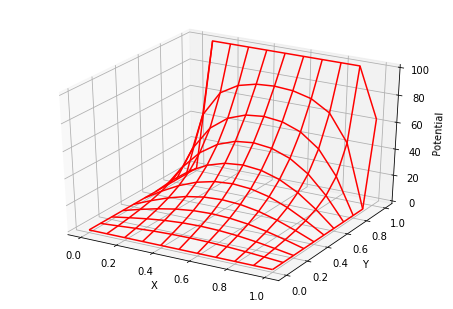

In [1]:
""" From "COMPUTATIONAL PHYSICS" & "COMPUTER PROBLEMS in PHYSICS"
    by RH Landau, MJ Paez, and CC Bordeianu (deceased)
    Copyright R Landau, Oregon State Unv, MJ Paez, Univ Antioquia, 
    C Bordeianu, Univ Bucharest, 2017. 
    Please respect copyright & acknowledge our work."""
    
 
# LaplaceFEM_2D.py solve 2D Laplace Eq via Finite elements method; utf-8coding 

""" Dirichlet boundary conditions surrounding four walls 
 Domain dimensions: WxH, with 2 triangles per square  
 Based on FEM2DL_Box Matlab program in Polycarpou, Intro to the Finite 
 Element Method in Electromagnetics, Morgan & Claypool (2006) """

from numpy import *
from numpy.linalg import solve
import pylab as p
from mpl_toolkits.mplot3d import Axes3D

# Num squares, nodes, triangles, mesh coords, Initialization

Width = 1.;    Height = 1.;  Nx = 20;   Ny = 20; U0 = 100
Xurc = Width;  Yurc = Height;   Yllc = 0;   Xllc = 0
Ns = Nx * Ny;  Nn = (Nx + 1)*(Ny + 1)
Dx = (Xurc-Xllc)/Nx;    Dy = (Yurc-Yllc)/Ny;   Ne = 2 * Ns
ge = zeros(Ne, float)
x = zeros(Ne, float);      y = zeros(Ne, float)
Ebcnod = zeros(Ne, int);   Ebcval = zeros(Ne, int)
node = zeros((Ne + 1, Ne + 1), int)

for i in range(1, Nn + 1):
    x[i] = (i - 1) % (Nx + 1) * Dx
    y[i] = floor((i - 1) / (Nx + 1)) * Dy

# Connectivity Information
for i in range(1, Ns + 1):
    node[2 * i - 1, 1] = i + floor((i - 1) / Nx)
    node[2 * i - 1, 2] = node[2 * i - 1, 1] + 1 + Nx + 1
    node[2 * i - 1, 3] = node[2 * i - 1, 1] + 1 + Nx + 1 - 1
    node[2 * i, 1] = i + floor((i - 1) / Nx)
    node[2 * i, 2] = node[2 * i, 1] + 1
    node[2 * i, 3] = node[2 * i, 1] + 1 + Nx + 1

# Dirichlet Boundary Conditions
Tnebc = 0
for i in range(0, Nn):
    if x[i] == Xllc or x[i] == Xurc or y[i] == Yllc:
        Tnebc = Tnebc + 1
        Ebcnod[Tnebc] = i
        Ebcval[Tnebc] = 0
    elif y[i] == Yurc:
        Tnebc = Tnebc + 1
        Ebcnod[Tnebc] = i
        Ebcval[Tnebc] = U0

# Initialize A matrix, b vector, form matrix
A = zeros((Nn + 1, Nn + 1), float)
b = zeros((Nn + 1, 1), float)
for e in range(1, Ne):
    x21 = x[node[e, 2]] - x[node[e, 1]]
    x31 = x[node[e, 3]] - x[node[e, 1]]
    x32 = x[node[e, 3]] - x[node[e, 2]]
    x13 = x[node[e, 1]] - x[node[e, 3]]
    y12 = y[node[e, 1]] - y[node[e, 2]]
    y21 = y[node[e, 2]] - y[node[e, 1]]
    y31 = y[node[e, 3]] - y[node[e, 1]]
    y23 = y[node[e, 2]] - y[node[e, 3]]
    J = x21 * y31 - x31 * y21

# Evaluate A matrix, element vector ge
    A[1, 1] = -(y23 * y23 + x32 * x32) / (2 * J)
    A[1, 2] = -(y23 * y31 + x32 * x13) / (2 * J)
    A[2, 1] = A[1, 2]
    A[1, 3] = -(y23 * y12 + x32 * x21) / (2 * J)
    A[3, 1] = A[1, 3]
    A[2, 2] = -(y31 * y31 + x13 * x13) / (2 * J)
    A[2, 3] = -(y31 * y12 + x13 * x21) / (2 * J)
    A[3, 2] = A[2, 3]
    A[3, 3] = -(y12 * y12 + x21 * x21) / (2 * J)
    ge[1] = 0
    ge[2] = 0
    ge[3] = 0

# Evaluate element pe & update A matrix
    for i in  range(1, 4):
        for j in range(1, 4):
            A[node[e, i], node[e, j]] = A[node[e, i], node[e, j]] \
                + A[i, j]
        b[node[e, i]] = b[node[e, i]] + ge[i]

# Imposition of Dirichlet boundary conditions
for i in  range(1, Tnebc):
    for j in  range(1, Nn + 1):
        if j != Ebcnod[i]:
            b[j] = b[j] - A[j, Ebcnod[i]] * Ebcval[i]
    A[Ebcnod[i], :] = 0
    A[:, Ebcnod[i]] = 0
    A[Ebcnod[i], Ebcnod[i]] = 1
    b[Ebcnod[i]] = Ebcval[i]

# Solution, place on grid, plot
V = linalg.solve(A, b)
(X, Y) = p.meshgrid(arange(Xllc, Xurc + 0.1, 0.1 * (Xurc - Xllc)),
                    arange(Yllc, Yurc + 0.1, 0.1 * (Yurc - Yllc)))
Vgrid = zeros((11, 11), float)
for i in arange(1, 11):
    for j in arange(1, 11):
        for e in  range(0, Ne):
            x2p = x[node[e, 2]] - X[i, j]
            x3p = x[node[e, 3]] - X[i, j]
            y2p = y[node[e, 2]] - Y[i, j]
            y3p = y[node[e, 3]] - Y[i, j]
            A1 = 0.5 * abs(x2p * y3p - x3p * y2p)
            x2p = x[node[e, 2]] - X[i, j]
            x1p = x[node[e, 1]] - X[i, j]
            y2p = y[node[e, 2]] - Y[i, j]
            y1p = y[node[e, 1]] - Y[i, j]
            A2 = 0.5 * abs(x2p * y1p - x1p * y2p)
            x1p = x[node[e, 1]] - X[i, j]
            y21 = y[node[e, 2]] - y[node[e, 1]]
            y1p = y[node[e, 1]] - Y[i, j]
            x21 = x[node[e, 2]] - x[node[e, 1]]
            A3 = 0.5 * abs(x1p * y3p - x3p * y1p)
            y3p = y[node[e, 3]] - Y[i, j]
            x31 = x[node[e, 3]] - x[node[e, 1]]
            x3p = x[node[e, 3]] - X[i, j]
            y31 = y[node[e, 3]] - y[node[e, 1]]
            J = x21 * y31 - x31 * y21
            if abs(J / 2 - (A1 + A2 + A3)) < 0.00001 * J / 2:
                ksi = (y31 * (X[i, j] - x[node[e, 1]]) - x31 * (Y[i, j]
                       - y[node[e, 1]])) / J
                ita = (-y21 * (X[i, j] - x[node[e, 1]]) + x21 * (Y[i,
                       j] - y[node[e, 1]])) / J
                N1 = 1 - ksi - ita
                N2 = ksi
                N3 = ita
                Vgrid[i, j] = N1 * V[node[e, 1]] + N2 * V[node[e, 2]] \
                    + N3 * V[node[e, 3]]

# Plot the finite element solution of V using a contour plot
fig = p.figure()
ax = Axes3D(fig)
ax.plot_wireframe(X, Y, Vgrid, color='r')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Potential')
p.show()		